#### **Computing the Average Weighted Path (AWP) metric.**

To objectively quantify the non-random localization specific subjects (such as participants with a diagnosis), we need to compute the average weighted path metric and compare it against a null distribution (created by computing X iterations with randomly selected subjects). Then, we compute the p-value associated with this specific condition by comparing the value to the null distribution. 

**This process is a *REALLY* long running process (the results in Gagnon et al. have been computed on high performance computer clusters). The CLI script are detailed below, but it shouldn't be run on a local computer as it can take up to 7 days using all available resources. If you want to try it, reduce the number of iterations to maximum a 100.**

The AWP will be computed using data from all studies and individually for those specific variables:

1. Anxiety Disorder (AD)
1. Attention Deficit-Hyperactivity Disorder (ADHD)
1. Conduct Disorder (CD)
1. Depressive Disorder (DD)
1. Obsessive-compulsive disorder (OCD)
1. Oppositional Defiant Disorder (ODD)
1. Psychopathology index (at least one of the above diagnosis)

In [8]:
# Imports
import os

from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import false_discovery_control

from neurostatx.io.utils import load_df_in_any_format
from neurostatx.network.utils import fetch_attributes_df, fetch_edge_data

In [9]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [2]:
# Setting up relevant paths.
repository_path = "/Users/anthonygagnon/code/Article-s-Code/" # CHANGE THIS
abcd_base_path = "/Volumes/T7/CCPM/ABCD/Release_5.1/abcd-data-release-5.1/" # CHANGE THIS
geste_base_dir = "/Volumes/T7/CCPM/GESTE/" # CHANGE THIS
banda_dir = '/Volumes/T7/CCPM/BANDA/BANDARelease1.1/' # CHANGE THIS
output_folder = "/Volumes/T7/CCPM/RESULTS_JUNE_24/" # CHANGE THIS
data_dir = f"{output_folder}/fuzzyclustering/"
output_dir = f"{output_folder}/awp/"

# Create output directory if it does not exist.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### **Running the AWP computation using all studies**

The following cell contains the CLI script to run in order to compute the AWP for all variables using data from the three cohorts. **As mentioned above, to test it, reduce the iterations to at least 100 and select the number of cores to use (using the --processes flag).**

In [ ]:
# Running AWP computations using all studies.

!AverageWeightedPath --in-graph "{data_dir}/GraphNetwork.gml" --iterations 5000 --weight membership \
    --method dijkstra --processes 40 --out-folder "{output_dir}/AWP_GLOBAL/" --label-name AD --label-name ADHD \
    --label-name CD --label-name DD --label-name OCD --label-name ODD --label-name PSYPATHO -v -s -f

#### **Running the AWP computation using the ABCD cohort**

The following cell contains the CLI script to run in order to compute the AWP for all variables using data from the ABCD cohort. **As mentioned above, to test it, reduce the iterations to at least 100 and select the number of cores to use (using the --processes flag).**

In [ ]:
# Running AWP computations using the ABCD study.

!AverageWeightedPath --in-graph "{data_dir}/GraphNetwork.gml" --cohort 1 --iterations 5000 --weight membership \
    --method dijkstra --processes 40 --out-folder "{output_dir}/AWP_ABCD/" --label-name AD --label-name ADHD \
    --label-name CD --label-name DD --label-name OCD --label-name ODD --label-name PSYPATHO -v -s -f

#### **Running the AWP computation using the BANDA cohort**

The following cell contains the CLI script to run in order to compute the AWP for all variables using data from the BANDA cohort. **As mentioned above, to test it, reduce the iterations to at least 100 and select the number of cores to use (using the --processes flag).**

In [ ]:
# Running AWP computations using the BANDA study.

!AverageWeightedPath --in-graph "{data_dir}/GraphNetwork.gml" --cohort 2 --iterations 5000 --weight membership \
    --method dijkstra --processes 40 --out-folder "{output_dir}/AWP_BANDA/" --label-name AD --label-name ADHD \
    --label-name DD --label-name OCD --label-name ODD --label-name PSYPATHO -v -s -f

#### **Running the AWP computation using the GESTE cohort**

The following cell contains the CLI script to run in order to compute the AWP for all variables using data from the GESTE cohort. **As mentioned above, to test it, reduce the iterations to at least 100 and select the number of cores to use (using the --processes flag).**

In [ ]:
# Running AWP computations using the GESTE study.

!AverageWeightedPath --in-graph "{data_dir}/GraphNetwork.gml" --cohort 3 --iterations 5000 --weight membership \
    --method dijkstra --processes 40 --out-folder "{output_dir}/AWP_GESTE/" --label-name ADHD \
    --label-name PSYPATHO -v -s -f

#### **Load back the results to apply FDR correction.**

Since we are performing a lot of statistical test (one for each diagnosis), we will correct the resulting p-values using the Benjamini-Hochberg [1] method. 

[1] Benjamini, Yoav, and Yosef Hochberg. “Controlling the false discovery rate: a practical and powerful approach to multiple testing.” Journal of the Royal statistical society: series B (Methodological) 57.1 (1995): 289-300.

In [ ]:
# For the global AWP computations.
# Load back the computed AWP values. Since they are in different files, we need to load them separately, append the p-values to a list, perform FDR correction, and append them to the original data frame. This will be done using 2 for loops (not the most efficient way, but it works).
diagnosis = ['AD', 'ADHD', 'CD', 'DD', 'OCD', 'ODD', 'PSYPATHO']

pvals = []
for dx in diagnosis:
    results = load_df_in_any_format(f'{output_dir}/AWP_GLOBAL/statistics_{dx}.xlsx')
    pvals.append(results.iloc[1, 1])

# Perform FDR correction.
pval_corrected = false_discovery_control(pvals, method='bh')

# Append the corrected p-values to the original data frame.
for i, dx in enumerate(diagnosis):
    results = load_df_in_any_format(f'{output_dir}/AWP_GLOBAL/statistics_{dx}.xlsx')
    results.columns = ['Index', 'Statistics']
    results.set_index('Index', inplace=True)
    results.loc['FDR-corrected pval'] = pval_corrected[i]
    results.to_excel(f'{output_dir}/AWP_GLOBAL/statistics_{dx}.xlsx', index=True,
                     header=True)

In [5]:
# For the ABCD study.
# Load back the computed AWP values. Since they are in different files, we need to load them separately, append the p-values to a list, perform FDR correction, and append them to the original data frame. This will be done using 2 for loops (not the most efficient way, but it works).
diagnosis = ['AD', 'ADHD', 'CD', 'DD', 'OCD', 'ODD', 'PSYPATHO']

pvals = []
for dx in diagnosis:
    results = load_df_in_any_format(f'{output_dir}/AWP_ABCD/statistics_{dx}.xlsx')
    pvals.append(results.iloc[1, 1])

# Perform FDR correction.
pval_corrected = false_discovery_control(pvals, method='bh')

# Append the corrected p-values to the original data frame.
for i, dx in enumerate(diagnosis):
    results = load_df_in_any_format(f'{output_dir}/AWP_ABCD/statistics_{dx}.xlsx')
    results.columns = ['Index', 'Statistics']
    results.set_index('Index', inplace=True)
    results.loc['FDR-corrected pval'] = pval_corrected[i]
    results.to_excel(f'{output_dir}/AWP_ABCD/statistics_{dx}.xlsx', index=True,
                     header=True)

In [6]:
# For the BANDA study.
# Load back the computed AWP values. Since they are in different files, we need to load them separately, append the p-values to a list, perform FDR correction, and append them to the original data frame. This will be done using 2 for loops (not the most efficient way, but it works).
diagnosis = ['AD', 'ADHD', 'DD', 'OCD', 'ODD', 'PSYPATHO']

pvals = []
for dx in diagnosis:
    results = load_df_in_any_format(f'{output_dir}/AWP_BANDA/statistics_{dx}.xlsx')
    pvals.append(results.iloc[1, 1])

# Perform FDR correction.
pval_corrected = false_discovery_control(pvals, method='bh')

# Append the corrected p-values to the original data frame.
for i, dx in enumerate(diagnosis):
    results = load_df_in_any_format(f'{output_dir}/AWP_BANDA/statistics_{dx}.xlsx')
    results.columns = ['Index', 'Statistics']
    results.set_index('Index', inplace=True)
    results.loc['FDR-corrected pval'] = pval_corrected[i]
    results.to_excel(f'{output_dir}/AWP_BANDA/statistics_{dx}.xlsx', index=True,
                     header=True)

In [7]:
# For the GESTE study.
# Load back the computed AWP values. Since they are in different files, we need to load them separately, append the p-values to a list, perform FDR correction, and append them to the original data frame. This will be done using 2 for loops (not the most efficient way, but it works).
diagnosis = ['ADHD', 'PSYPATHO']

pvals = []
for dx in diagnosis:
    results = load_df_in_any_format(f'{output_dir}/AWP_GESTE/statistics_{dx}.xlsx')
    pvals.append(results.iloc[1, 1])

# Perform FDR correction.
pval_corrected = false_discovery_control(pvals, method='bh')

# Append the corrected p-values to the original data frame.
for i, dx in enumerate(diagnosis):
    results = load_df_in_any_format(f'{output_dir}/AWP_GESTE/statistics_{dx}.xlsx')
    results.columns = ['Index', 'Statistics']
    results.set_index('Index', inplace=True)
    results.loc['FDR-corrected pval'] = pval_corrected[i]
    results.to_excel(f'{output_dir}/AWP_GESTE/statistics_{dx}.xlsx', index=True,
                     header=True)

#### **Computing the Average Weighted Path (AWP) metric for KSADS youth data in the ABCD cohort.**

To objectively quantify the non-random localization specific subjects (such as participants with a diagnosis), we need to compute the average weighted path metric and compare it against a null distribution (created by computing X iterations with randomly selected subjects). Then, we compute the p-value associated with this specific condition by comparing the value to the null distribution. 

**This process is a *REALLY* long running process (the results in Gagnon et al. have been computed on high performance computer clusters). The CLI script are detailed below, but it shouldn't be run on a local computer as it can take up to 7 days using all available resources. If you want to try it, reduce the number of iterations to maximum a 100.**

The AWP will be computed using youth KSADS data from ABCD and individually for those specific variables:

1. Anxiety Disorder (AD)
1. Depressive Disorder (DD)

In [4]:
# Fetch diagnosis labels for the youth data.
!python {repository_path}/scripts/generate_dx_ABCD_youth.py --in-root-folder {abcd_base_path} --output {output_dir}/ABCD_youth_dx.xlsx

/Users/anthonygagnon/code/Article-s-Code//scripts/generate_dx_ABCD_youth.py:53: DtypeWarning: Columns (2,956,1286,1287) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ksads = pd.read_csv(


In [15]:
# Load back the youth KSADS label and compute a PSYPATHO label.
abcd_youth_ksads = load_df_in_any_format(f'{output_dir}/ABCD_youth_dx.xlsx')

abcd_youth_ksads.loc[:, "PSYPATHO_youth"] = abcd_youth_ksads.iloc[:, 1:].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

abcd_youth_ksads.to_excel(f'{output_dir}/ABCD_youth_dx.xlsx', index=False, header=True)

In [17]:
# Add new youth diagnosis to the Graph Network file.
!AddNodesAttributes --in-graph "{data_dir}/GraphNetwork.gml" \
    --in-dataset "{output_dir}/ABCD_youth_dx.xlsx" \
    --labels AD_youth --labels DD_youth --labels PSYPATHO_youth \
    --id-column subjectkey \
    --out-file "{output_dir}/GraphNetwork_youth.gml" \
    -v -f

2024-11-11 13:57:50 Anthonys-MacBook-Pro.local root[11043] INFO Loading graph and dataset.
2024-11-11 13:57:53 Anthonys-MacBook-Pro.local root[11043] INFO Constructing dictionary of attributes to add.
2024-11-11 13:57:53 Anthonys-MacBook-Pro.local root[11043] INFO Adding attributes to graph.
2024-11-11 13:57:53 Anthonys-MacBook-Pro.local root[11043] INFO Saving graph.


#### **Running the AWP computation using the ABCD cohort with youth diagnosis data.**

The following cell contains the CLI script to run in order to compute the AWP for all variables using data from the ABCD cohort. **As mentioned above, to test it, reduce the iterations to at least 100 and select the number of cores to use (using the --processes flag).**

In [18]:
# Running AWP computations using the ABCD youth data.
!AverageWeightedPath --in-graph "{output_dir}/GraphNetwork_youth.gml" --cohort 1 --iterations 5000 --weight membership \
    --method dijkstra --processes 8 --out-folder "{output_dir}/AWP_ABCD_youth/" --label-name AD_youth --label-name DD_youth \
    --label-name PSYPATHO_youth -v -s -f

2024-11-11 13:58:13 Anthonys-MacBook-Pro.local root[11355] INFO Loading graph.
2024-11-11 13:58:16 Anthonys-MacBook-Pro.local root[11355] INFO Computing average weighted path for variable : AD_youth
2024-11-11 13:58:17 Anthonys-MacBook-Pro.local root[11355] INFO Computing weighted path for the set of nodes.
2024-11-11 13:58:17 Anthonys-MacBook-Pro.local root[11355] INFO Computing null distribution.
100%|█████████████████████████████████████| 5000/5000 [1:50:21<00:00,  1.32s/it]
2024-11-11 15:48:41 Anthonys-MacBook-Pro.local root[11355] INFO Computing average weighted path for variable : DD_youth
2024-11-11 15:48:42 Anthonys-MacBook-Pro.local root[11355] INFO Computing weighted path for the set of nodes.
2024-11-11 15:48:42 Anthonys-MacBook-Pro.local root[11355] INFO Computing null distribution.
100%|█████████████████████████████████████| 5000/5000 [1:50:02<00:00,  1.32s/it]
2024-11-11 17:38:46 Anthonys-MacBook-Pro.local root[11355] INFO Computing average weighted path for variable : PS

In [19]:
# Compute the fdr correction for the AWP results.
diagnosis = ['AD_youth', 'DD_youth', 'PSYPATHO_youth']

pvals = []
for dx in diagnosis:
    results = load_df_in_any_format(f'{output_dir}/AWP_ABCD_youth/statistics_{dx}.xlsx')
    pvals.append(results.iloc[1, 1])

# Perform FDR correction.
pval_corrected = false_discovery_control(pvals, method='bh')

# Append the corrected p-values to the original data frame.
for i, dx in enumerate(diagnosis):
    results = load_df_in_any_format(f'{output_dir}/AWP_ABCD_youth/statistics_{dx}.xlsx')
    results.columns = ['Index', 'Statistics']
    results.set_index('Index', inplace=True)
    results.loc['FDR-corrected pval'] = pval_corrected[i]
    results.to_excel(f'{output_dir}/AWP_ABCD_youth/statistics_{dx}.xlsx', index=True,
                     header=True)

In [3]:
# Fetch the graph network with youth data.
G = nx.read_gml(f"{output_dir}/GraphNetwork_youth.gml")

# Fetch the membership and attributes of the youth data.
attributes_df = fetch_attributes_df(G, attributes='')
edges_df = fetch_edge_data(G)

# Fetching highest membership value for each node.
attributes_df.loc[:, 'profiles'] = np.argmax(edges_df.values, axis=1) + 1

# Isolating ABCD data.
abcd_df = attributes_df[attributes_df['cohort'] == 1]

In [4]:
# Computing percentage for the abcd dataset with youth diagnosis.
abcd_perc = []
for dx in ['AD_youth', 'DD_youth']:
    for profile in np.unique(abcd_df[['profiles']]):
        profile_df = abcd_df[abcd_df['profiles'] == profile]
        abcd_perc.append(profile_df[profile_df.loc[:, dx] == 1][dx].sum() / abcd_df[dx].sum() * 100)

In [5]:
# Setting the DataFrame vertically
abcd_perc_v = pd.DataFrame(np.array(abcd_perc),
                    columns=['values'],
                    index=['MC/HSI (c1)', 'MC/HE (c2)', 'HC/LB (c3)', 'LC/LB (c4)'] * 2)
abcd_perc_v['group'] = np.repeat(['AD', 'DD'], 4)
abcd_perc_v['cohort'] = 'ABCD'

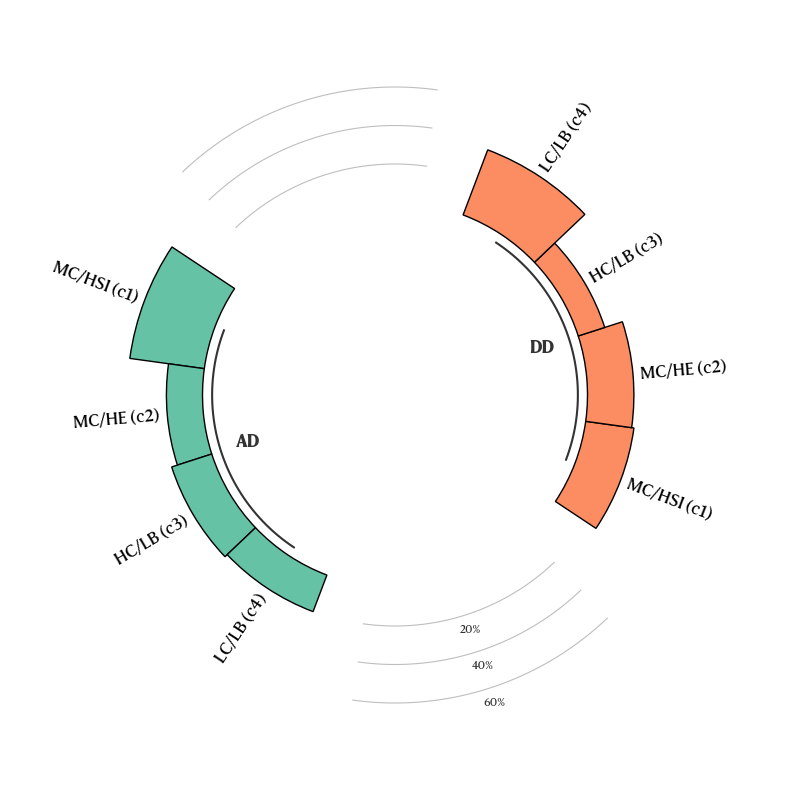

In [11]:
# Useful functions
def add_labels(angles, values, labels, offset, ax):
    padding = 4
    for angle, value, label in zip(angles, values, labels):
        rotation, alignment = get_label_rotation(angle, offset)
        ax.text(x=angle,
                y=value + padding,
                s=label,
                ha=alignment,
                va='center',
                rotation=rotation,
                rotation_mode='anchor')

# Has to be defined for each plot, as the angle is different.
def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi / 1 or angle >= 3 * np.pi / 1:
        alignment = 'right'
        rotation = rotation + 180
    else:
        alignment = 'left'
        rotation = rotation 
    return rotation, alignment

# Circular barplot.
values=abcd_perc_v['values'].values
labels=abcd_perc_v.index
group = abcd_perc_v['group'].values

# Create space between clusters.
pad = 3
angles_n = len(values) + pad * len(np.unique(group))
angles = np.linspace(0, 2 * np.pi, num=angles_n, endpoint=False)

# Set the width of each bar + offset for the first one.
width = 2 * np.pi / len(angles)
offset = 0

# Getting the size of each group.
group_size = [len(i[1]) for i in abcd_perc_v.groupby('group')]
idxs = []
for size in group_size:
    idxs += list(range(offset + pad, offset + size + pad))
    offset += size + pad

# Create the figure and the axis.
with plt.rc_context(
        {"font.size": 12, "font.weight": "normal", "axes.titleweight": "bold",
         "font.family": "Harding Text Web"}
    ):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"})

    ax.set_theta_offset(offset)
    ax.set_frame_on(False)

    # Set limits.
    ax.set_ylim(-100, 100)

    # Remove grid and tick marks.
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])

    # Set colors
    colors = sns.color_palette("Set2", n_colors=7)
    color = [colors[i] for i, size in enumerate(group_size) for _ in range(size)]

    # Plot the bars.
    ax.bar(angles[idxs], values, width=width, linewidth=1, color=color, edgecolor="black")

    # Add labels.
    add_labels(angles[idxs], values, labels, offset, ax)

    # Adding reference lines and group indicators.
    offset = 0
    for group, size in zip(np.unique(abcd_perc_v['group'].values), group_size):
        x1 = np.linspace(angles[offset + pad], angles[offset + size + pad - 1], num=50)
        ax.plot(x1, [-5] * 50, color="#333333")

        # add group indicators.
        ax.text(
            np.mean(x1), -20, group, color="#333333", fontsize=12,
            fontweight="bold", ha="center", va="center"
        )

        # Add reference lines.
        x2 = np.linspace(angles[offset], angles[offset + pad - 1], num=50)
        ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)

        offset += size + pad

    # Add label to single reference bar. 
    ax.text(
        np.mean(x2), 68, '60%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )
    ax.text(
        np.mean(x2), 48, '40%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )
    ax.text(
        np.mean(x2), 28, '20%', color="#333333", fontsize=8,
        fontweight="normal", ha="center", va="center", rotation=0
    )

    plt.savefig(f'{output_dir}/circular_ABCD_youth_dx.png', dpi=900)
    plt.show()